## A8 - Spatial data and Magic: The Gathering

In [2]:
%load_ext sql

In [3]:
%matplotlib inline

In [4]:
%sql postgresql://appdev@data/appdev

'Connected: appdev@appdev'

### 1.
In the first part you'll be processing the data in the `geonames` table.
* Find the tuple with the largest population

In [6]:
%%sql SELECT *
FROM geonames ORDER BY population DESC LIMIT 1;

1 rows affected.


geonameid,name,longitude,latitude,feature_class,feature_code,country_code,admin1_code,admin2_code,population,elevation,timezone
305104,Levant,36.0,34.0,L,RGN,None,None,None,44990000,None,Asia/Beirut


* Now calculate the distance from all locations to the tuple above using the `<->` function

In [7]:
%%sql SELECT point(36, 34) <-> point(longitude,latitude) AS distance
FROM geonames ORDER BY distance DESC LIMIT 10;

10 rows affected.


distance
243.041567580299
226.392811281631
226.321369487677
224.32621893127
221.784518170228
221.778802715178
221.732030326899
221.675705901411
221.554254857319
221.550265350276


### 2.
Now calculate the distance from all locations to the tuple above using the haversine distance

The haversine distance has been implemented in PL/PGSQL here: https://gist.github.com/carlzulauf/1724506

In [8]:
%%sql CREATE OR REPLACE FUNCTION public.geodistance(alat double precision,
                                                    alng double precision,
                                                    blat double precision,
                                                    blng double precision)
  RETURNS double precision AS
$BODY$
SELECT asin(
  sqrt(
    sin(radians($3-$1)/2)^2 +
    sin(radians($4-$2)/2)^2 *
    cos(radians($1)) *
    cos(radians($3))
  )
) * 7926.3352 AS distance;
$BODY$
  LANGUAGE sql IMMUTABLE
  COST 100;

Done.


[]

In [9]:
%%sql SELECT geodistance(36,34, latitude, longitude) AS geodistance
FROM geonames ORDER BY geodistance DESC LIMIT 10;

10 rows affected.


geodistance
11605.6272671968
11603.3351072272
11583.0474048111
11263.9466814205
11178.3692001669
11175.0977221625
11171.8850726579
11168.4090550694
11166.1326287561
11164.0201976944


### 3.
Plot the latitude and longitude of the largest 1000 populations on a 2-D scatter plot

You can use IPython-SQL or Pandas to create the plot

In [20]:
result = %sql SELECT longitude, latitude FROM geonames ORDER BY population DESC LIMIT 1000;

1000 rows affected.


**For some reason IPythong-SQL's `.plot()` function doesn't work and just gives me an error.**

In [21]:
result.plot();

NameError: name 'reduce' is not defined

**Instead, I have used the `.bar()` function below, but it is not that useful as the longitude values are unreadable. It was the only thing I could use to vizualise my results though.**

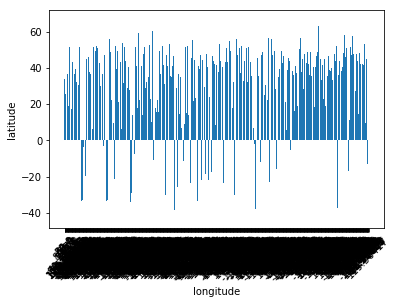

In [38]:
result.bar();

### 4.
In the second part your job is to work with JSON data from the magic schema. The schema is based on the game Magic: The Gathering
* Find all the cards that is made by Rob Alexander

In [22]:
%sql SELECT * FROM cards WHERE data @> '{"artist":"Rob Alexander"}' LIMIT 10;

10 rows affected.


set,data
10E,"{'id': '4a7bf234af44e07d9a159d4d89e96ce320919917', 'cmc': 6, 'name': 'Beacon of Immortality', 'text': ""Double target player's life total. Shuffle Beacon of Immortality into its owner's library."", 'type': 'Instant', 'types': ['Instant'], 'artist': 'Rob Alexander', 'colors': ['White'], 'flavor': 'The cave floods with light. A thousand rays shine forth and meld into one.', 'layout': 'normal', 'number': '10', 'rarity': 'Rare', 'manaCost': '{5}{W}', 'imageName': 'beacon of immortality', 'mciNumber': '10', 'multiverseid': 130553, 'colorIdentity': ['W']}"
10E,"{'id': '9cea331c080c3bbc7987c6560f65e39e9d1ed34f', 'cmc': 5, 'name': 'Kavu Climber', 'text': 'When Kavu Climber enters the battlefield, draw a card.', 'type': 'Creature — Kavu', 'power': '3', 'types': ['Creature'], 'artist': 'Rob Alexander', 'colors': ['Green'], 'flavor': '""There was a crack of branches, a rustle of leaves, then a tremendous roar. Our party had no chance as death descended from above.""\n—Taseen, elvish bard', 'layout': 'normal', 'number': '273', 'rarity': 'Common', 'manaCost': '{3}{G}{G}', 'subtypes': ['Kavu'], 'imageName': 'kavu climber', 'mciNumber': '273', 'toughness': '3', 'multiverseid': 129511, 'colorIdentity': ['G']}"
10E,"{'id': '28cc7c79cca8939fd9661f7abfc6ca453715b75e', 'cmc': 0, 'name': 'Llanowar Wastes', 'text': '{T}: Add {C} to your mana pool.\n{T}: Add {B} or {G} to your mana pool. Llanowar Wastes deals 1 damage to you.', 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '355', 'rarity': 'Rare', 'imageName': 'llanowar wastes', 'mciNumber': '355', 'multiverseid': 129627, 'colorIdentity': ['B', 'G']}"
10E,"{'id': '7a90b7ba6197f8774ed99ecf75ac9abb3e0c0f20', 'cmc': 0, 'name': 'Shivan Reef', 'text': '{T}: Add {C} to your mana pool.\n{T}: Add {U} or {R} to your mana pool. Shivan Reef deals 1 damage to you.', 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '357', 'rarity': 'Rare', 'imageName': 'shivan reef', 'mciNumber': '357', 'multiverseid': 129731, 'colorIdentity': ['U', 'R']}"
10E,"{'id': '8d1035f151615c949d0645b70fe01d8ab4a3f796', 'cmc': 0, 'name': 'Sulfurous Springs', 'text': '{T}: Add {C} to your mana pool.\n{T}: Add {B} or {R} to your mana pool. Sulfurous Springs deals 1 damage to you.', 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '359', 'rarity': 'Rare', 'imageName': 'sulfurous springs', 'mciNumber': '359', 'multiverseid': 129751, 'colorIdentity': ['B', 'R']}"
10E,"{'id': 'c97103ab834aad9b3fb7d07c4fb563089f97fe87', 'cmc': 0, 'name': 'Treetop Village', 'text': ""Treetop Village enters the battlefield tapped.\n{T}: Add {G} to your mana pool.\n{1}{G}: Treetop Village becomes a 3/3 green Ape creature with trample until end of turn. It's still a land. (If it would assign enough damage to its blockers to destroy them, you may have it assign the rest of its damage to defending player or planeswalker.)"", 'type': 'Land', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '361', 'rarity': 'Uncommon', 'imageName': 'treetop village', 'mciNumber': '361', 'multiverseid': 106455, 'colorIdentity': ['G']}"
10E,"{'id': '24a47bf9cb4596246501294e7127bf74e082bc1d', 'cmc': 0, 'name': 'Plains', 'type': 'Basic Land — Plains', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '364', 'rarity': 'Basic Land', 'subtypes': ['Plains'], 'imageName': 'plains1', 'watermark': 'White', 'supertypes': ['Basic'], 'variations': [129682, 129683, 129681], 'multiverseid': 129680, 'colorIdentity': ['W']}"
10E,"{'id': 'be5e30798e4f8b9b6f6e6a8dd2e30bf86bb04b94', 'cmc': 0, 'name': 'Forest', 'type': 'Basic Land — Forest', 'types': ['Land'], 'artist': 'Rob Alexander', 'layout': 'normal', 'number': '382', 'rarity': 'Basic Land', 'subtypes': ['Forest'], 'imageName': 'forest3', 'watermark': 'Green', 'supertypes': ['Basic'], 'variations': [129559, 129562, 129560], 'multiverseid': 129561, 'colorIde

* Find all the cards that have the subtype "Human"

In [23]:
%sql SELECT * FROM cards WHERE data @> '{"subtypes": ["Human"]}' LIMIT 10;

10 rows affected.


set,data
10E,"{'id': 'ab1ab474019e4e76c66e2b524d354cb7c3212616', 'cmc': 7, 'name': ""Ancestor's Chosen"", 'text': ""First strike (This creature deals combat damage before creatures without first strike.)\nWhen Ancestor's Chosen enters the battlefield, you gain 1 life for each card in your graveyard."", 'type': 'Creature — Human Cleric', 'power': '4', 'types': ['Creature'], 'artist': 'Pete Venters', 'colors': ['White'], 'flavor': '""The will of all, by my hand done.""', 'layout': 'normal', 'number': '1', 'rarity': 'Uncommon', 'manaCost': '{5}{W}{W}', 'subtypes': ['Human', 'Cleric'], 'imageName': ""ancestor's chosen"", 'mciNumber': '1', 'toughness': '4', 'multiverseid': 130550, 'colorIdentity': ['W']}"
10E,"{'id': 'd3488c0a916bd922856473155a8b49ec23fc2217', 'cmc': 4, 'name': 'Ballista Squad', 'text': '{X}{W}, {T}: Ballista Squad deals X damage to target attacking or blocking creature.', 'type': 'Creature — Human Rebel', 'power': '2', 'types': ['Creature'], 'artist': 'Matthew D. Wilson', 'colors': ['White'], 'flavor': 'The perfect antidote for a tightly packed formation.', 'layout': 'normal', 'number': '8', 'rarity': 'Uncommon', 'manaCost': '{3}{W}', 'subtypes': ['Human', 'Rebel'], 'imageName': 'ballista squad', 'mciNumber': '8', 'toughness': '2', 'multiverseid': 129477, 'colorIdentity': ['W']}"
10E,"{'id': '29c46fca29e5de01dba3bbf05393325bc9132735', 'cmc': 3, 'name': 'Benalish Knight', 'text': 'Flash (You may cast this spell any time you could cast an instant.)\nFirst strike (This creature deals combat damage before creatures without first strike.)', 'type': 'Creature — Human Knight', 'power': '2', 'types': ['Creature'], 'artist': 'Zoltan Boros & Gabor Szikszai', 'colors': ['White'], 'flavor': '""We called them \'armored lightning.\'""\n—Gerrard of the Weatherlight', 'layout': 'normal', 'number': '11', 'rarity': 'Common', 'manaCost': '{2}{W}', 'subtypes': ['Human', 'Knight'], 'imageName': 'benalish knight', 'mciNumber': '11', 'toughness': '2', 'multiverseid': 136279, 'colorIdentity': ['W']}"
10E,"{'id': 'e8b8dea65daf4e9070cce5de62bdbea0bf36d47c', 'cmc': 4, 'name': 'Cho-Manno, Revolutionary', 'text': 'Prevent all damage that would be dealt to Cho-Manno, Revolutionary.', 'type': 'Legendary Creature — Human Rebel', 'power': '2', 'types': ['Creature'], 'artist': 'Steven Belledin', 'colors': ['White'], 'flavor': '""Mercadia\'s masks can no longer hide the truth. Our day has come at last.""', 'layout': 'normal', 'number': '12', 'rarity': 'Rare', 'manaCost': '{2}{W}{W}', 'subtypes': ['Human', 'Rebel'], 'imageName': 'cho-manno, revolutionary', 'mciNumber': '12', 'toughness': '2', 'supertypes': ['Legendary'], 'multiverseid': 130554, 'colorIdentity': ['W']}"
10E,"{'id': '80a6b907fc380ed97615e8abc0fe6071c4ceef67', 'cmc': 3, 'name': 'Field Marshal', 'text': 'Other Soldier creatures get +1/+1 and have first strike. (They deal combat damage before creatures without first strike.)', 'type': 'Creature — Human Soldier', 'power': '2', 'types': ['Creature'], 'artist': 'Stephen Tappin', 'colors': ['White'], 'flavor': 'He is the only one who sees the patterns in the overlapping maps and conflicting reports.', 'layout': 'normal', 'number': '15', 'rarity': 'Rare', 'manaCost': '{1}{W}{W}', 'subtypes': ['Human', 'Soldier'], 'imageName': 'field marshal', 'mciNumber': '15', 'toughness': '2', 'multiverseid': 135258, 'colorIdentity': ['W']}"
10E,"{'id': '7879b835a2c3d6516515d03bd3a3894dceee1812', 'cmc': 1, 'name': 'Honor Guard', 'text': '{W}: Honor Guard gets +0/+1 until end of turn.', 'type': 'Creature — Human Soldier', 'power': '1', 'types': ['Creature'], 'artist': 'Dan Dos Santos', 'colors': ['White'], 'flavor': 'The strength of one. The courage of ten.', 'layout': 'normal', 'number': '23', 'rarity': 'Common', 'manaCost': '{W}', 'subtypes': ['Human', 'Soldier'], 'imageName': 'honor guard', 'mciNumber': '23', 'toughness': '1', 'multiverseid': 129595, 'colorIdentity': ['W']}"
10E,"{'id': '55932565b6905650e67e784b7cf0df63990e9851', 'cmc': 1, 'name': 'Icatia

* Group all the cards based on the colour. Aggregate them by counting the number of cards per colour.

In [26]:
%%sql SELECT data -> 'colors' AS colours, COUNT(data -> 'colors')
FROM cards GROUP BY data -> 'colors' ORDER BY count DESC;

32 rows affected.


colours,count
['Green'],4977
['Black'],4877
['Red'],4858
['White'],4755
['Blue'],4680
"['White', 'Green']",276
"['Red', 'Green']",273
"['Blue', 'Black']",260
"['Black', 'Red']",258
"['White', 'Blue']",245


**Unfortunately, I couldn't figure out how to make a histogram**